In [9]:
import json
import sys
import os
import datetime
import matplotlib.pyplot as plt
from finpricing.model import BondCurveAnalyticsHelper, BondCurveSolver
from finpricing.market import SurvivalCurveStep, SurvivalCurveNelsonSiegel
from finpricing.utils.tools import prettyTableByColumn
from finpricing.utils.plot import plot
# this assumes this notebook is running in the /docs folder and the data is in the /tests folder
sys.path.append(r'../tests')
from testing_utils.read_data import get_sample_bonds_portfolio, get_sample_discount_curve

## Read Reference and Market Data

We pick 10 bonds from the same issuer on 2023-10-09, and fix all the market data accordingly.

In [10]:
bonds, dirty_prices = get_sample_bonds_portfolio()
discount_curve      = get_sample_discount_curve()
valuation_date      = datetime.date(2023, 10, 9)
settlement_date     = datetime.date(2023, 10, 11)

In [22]:
prettyTableByColumn(
    {
        'Bond': bonds,
        'Dirty Price': dirty_prices
    },
    align='lr'
)

+------------------+--------------------+
| Bond             |        Dirty Price |
+------------------+--------------------+
| 5.7500% 03/01/24 | 100.62719107573301 |
| 5.8750% 02/15/25 | 102.85712222222223 |
| 3.6250% 06/15/25 |  97.45796188119483 |
| 3.6250% 06/15/25 |  97.45796188119483 |
| 4.3750% 11/15/26 |  97.87555555555555 |
| 4.8750% 04/15/28 |  98.73763333333333 |
| 5.8750% 11/15/28 | 102.61128888888888 |
| 6.3750% 05/15/29 | 104.84126718711933 |
| 5.3750% 11/15/29 |  98.47593444444445 |
| 4.8750% 06/15/30 |  95.09173333333334 |
+------------------+--------------------+


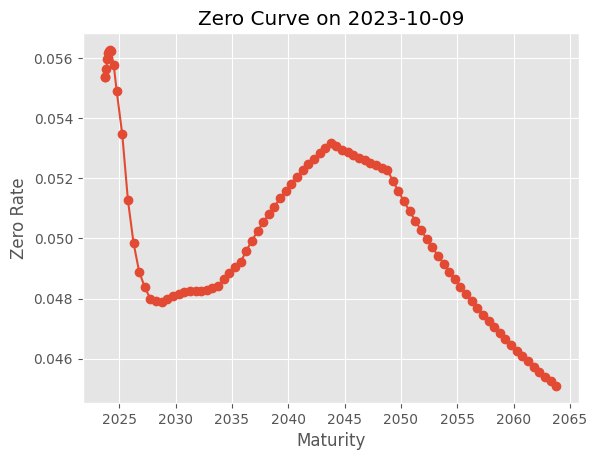

In [12]:
plot(discount_curve.dates,
     discount_curve.rates,
     title="Zero Curve on 2023-10-09",
     x_label="Maturity",
     y_label="Zero Rate",
     linestyle='-',
     marker='o')

## Bond Basis

Bond basis is the additional spread to add on top of the discount curve to match the marked price of the bond. Bond basis can be a broad topic, and can be calibrated on top of discount curve, or on top of a survival curve. Here, we assume this spread is added on top of the zero discount curve so that the model price matches the market price. Two notes are,

1. In absence of recovery and survival probability, the bond basis is the same as Z-spread.
2. A perfect recovery rate and survival curve should make the bond basis equal to zero.

### Z-Spread

As mentioned, while calibrating Z-Spread, recovery rate and survival curve are not considered, so we set them to zero and dummy values respectively. The `BondCurveAnalyticsHelper` creates a portfolio of bonds making easier to analyze the basket.
```

In [13]:
analyticsHelper = BondCurveAnalyticsHelper(bonds)
analyticsHelper.setup(
    settlement_dates=settlement_date,
    discount_curves=discount_curve,
    recovery_rates=0.,
    survival_curves=SurvivalCurveStep(anchor_date=valuation_date,
                                     dates = [valuation_date],
                                     hazard_rates=[0.],),
)
zspreads = analyticsHelper.get_bond_bases(
    valuation_date=valuation_date,
    dirty_prices=dirty_prices,
)

In [14]:
prettyTableByColumn(
    {
        'Numnber': range(1, len(bonds)+1),
        'Bond': bonds,
        'Z-Spread (bps)': (zspreads, '.4%')
    },
    align='llr'
)

+---------+------------------+----------------+
| Numnber | Bond             | Z-Spread (bps) |
+---------+------------------+----------------+
| 1       | 5.7500% 03/01/24 |        0.2011% |
| 2       | 5.8750% 02/15/25 |        0.5341% |
| 3       | 3.6250% 06/15/25 |        0.7554% |
| 4       | 3.6250% 06/15/25 |        0.7554% |
| 5       | 4.3750% 11/15/26 |        0.8962% |
| 6       | 4.8750% 04/15/28 |        1.0160% |
| 7       | 5.8750% 11/15/28 |        1.0303% |
| 8       | 6.3750% 05/15/29 |        1.0973% |
| 9       | 5.3750% 11/15/29 |        1.2124% |
| 10      | 4.8750% 06/15/30 |        1.2557% |
+---------+------------------+----------------+


## Bond Issuer Curve: Nelson Siegel Svensson Form

The calibration will search the best parameters for the NS curve that minimizes the unexplained error between the model price and the market price for all portfolio of bonds from the same issuer. Bond basis in this case is the "error" term, since we assume the survival curve is "correct", and ideally it could explain the price well.

In [15]:
# modify the recovery rate and survival curve for analyticsHelper
analyticsHelper.recovery_rates = 0.4
analyticsHelper.survival_curves = \
    SurvivalCurveNelsonSiegel(anchor_date=valuation_date,
                                pivot_dates=[datetime.date(2025, 6, 15),
                                datetime.date(2029, 5, 15)])
analyticsHelper.valuation_date = valuation_date

# build the solver
bondCurveSolver = BondCurveSolver(
    bondAnalyticsHelper = analyticsHelper
)

In [16]:
res = bondCurveSolver.solve(
    dirty_prices=dirty_prices,
)
res

(array([ 9.22536675e-05, -6.83825155e-02,  5.67154797e-02]), 2)